In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle

In [3]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

#Import Library

In [12]:
!pip install lazypredict
!pip install optuna
!pip install catboost
!pip install lightgbm
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler , PowerTransformer , RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split , cross_val_score , KFold

from lazypredict.Supervised import LazyRegressor
import optuna
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import  ExtraTreesRegressor , StackingRegressor , GradientBoostingRegressor

import lightgbm
import xgboost as xgb
import catboost

from IPython.display import display

#Datasets

## Download Datasets

In [5]:
! kaggle competitions download home-data-for-ml-course

100% 386k/386k [00:00<00:00, 669kB/s]
100% 386k/386k [00:00<00:00, 668kB/s]


In [6]:
! unzip home-data-for-ml-course.zip # Any Prediction type Competition

Archive:  home-data-for-ml-course.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: sample_submission.csv.gz  
  inflating: test.csv                
  inflating: test.csv.gz             
  inflating: train.csv               
  inflating: train.csv.gz            


## Load Datasets

In [15]:
# LOAD DATAFRAME

train_data = pd.read_table(r'/content/train.csv', sep=',')
test_data  = pd.read_table(r'/content/test.csv', sep=',')

print(f'Shape of Train data : {train_data.shape}')
print(f'Shape of Test data  : {test_data.shape}')

Shape of Train data : (1460, 81)
Shape of Test data  : (1459, 80)


In [17]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [18]:
test_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#EDA

##Dataset Information

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [20]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

### Null Value

In [23]:
train_data.isna().sum()

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


In [24]:
test_data.isna().sum()

,0
Id,0
MSSubClass,0
MSZoning,4
LotFrontage,227
LotArea,0
...,...
MiscVal,0
MoSold,0
YrSold,0
SaleType,1


In [26]:
train_null.drop(labels='SalePrice', axis=0, inplace=True)

In [28]:
train_null.compare(test_null).sort_values(by='self', ascending=False)

,self,other
PoolQC,1453.00,1456.00
MiscFeature,1406.00,1408.00
Alley,1369.00,1352.00
Fence,1179.00,1169.00
MasVnrType,872.00,894.00
FireplaceQu,690.00,730.00
LotFrontage,259.00,227.00
GarageType,81.00,76.00
GarageYrBlt,81.00,78.00
GarageFinish,81.00,78.00


###Percentage Comparison

In [29]:
# Convert into Dataframe
missing_value = pd.DataFrame(data=train_data.isna().sum(), index=train_data.columns, columns=['missing'])

# Add 'Percentage' Column
missing_value['Percentage'] = (missing_value['missing'] / 1460) * 100

# Sort By Descending
missing_value = missing_value.sort_values(by='Percentage',ascending=False)

missing_value.head(20)

,missing,Percentage
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55


###Null Visualization

(<Axes: >, <Axes: >)

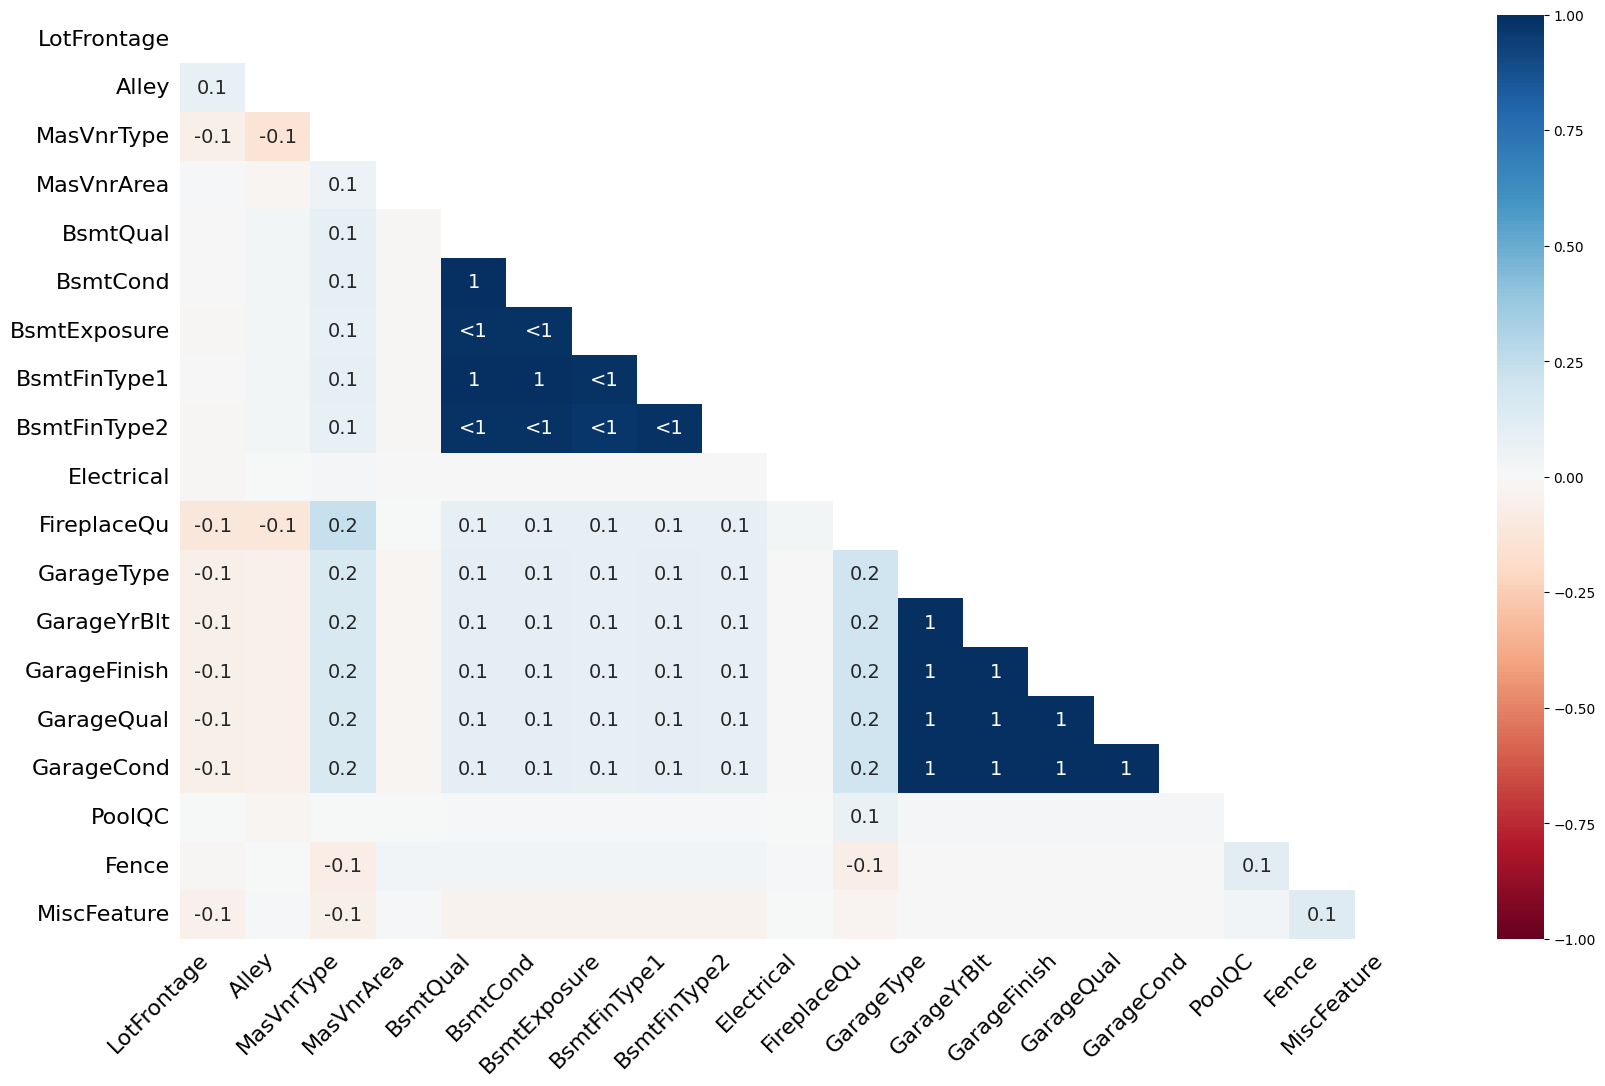

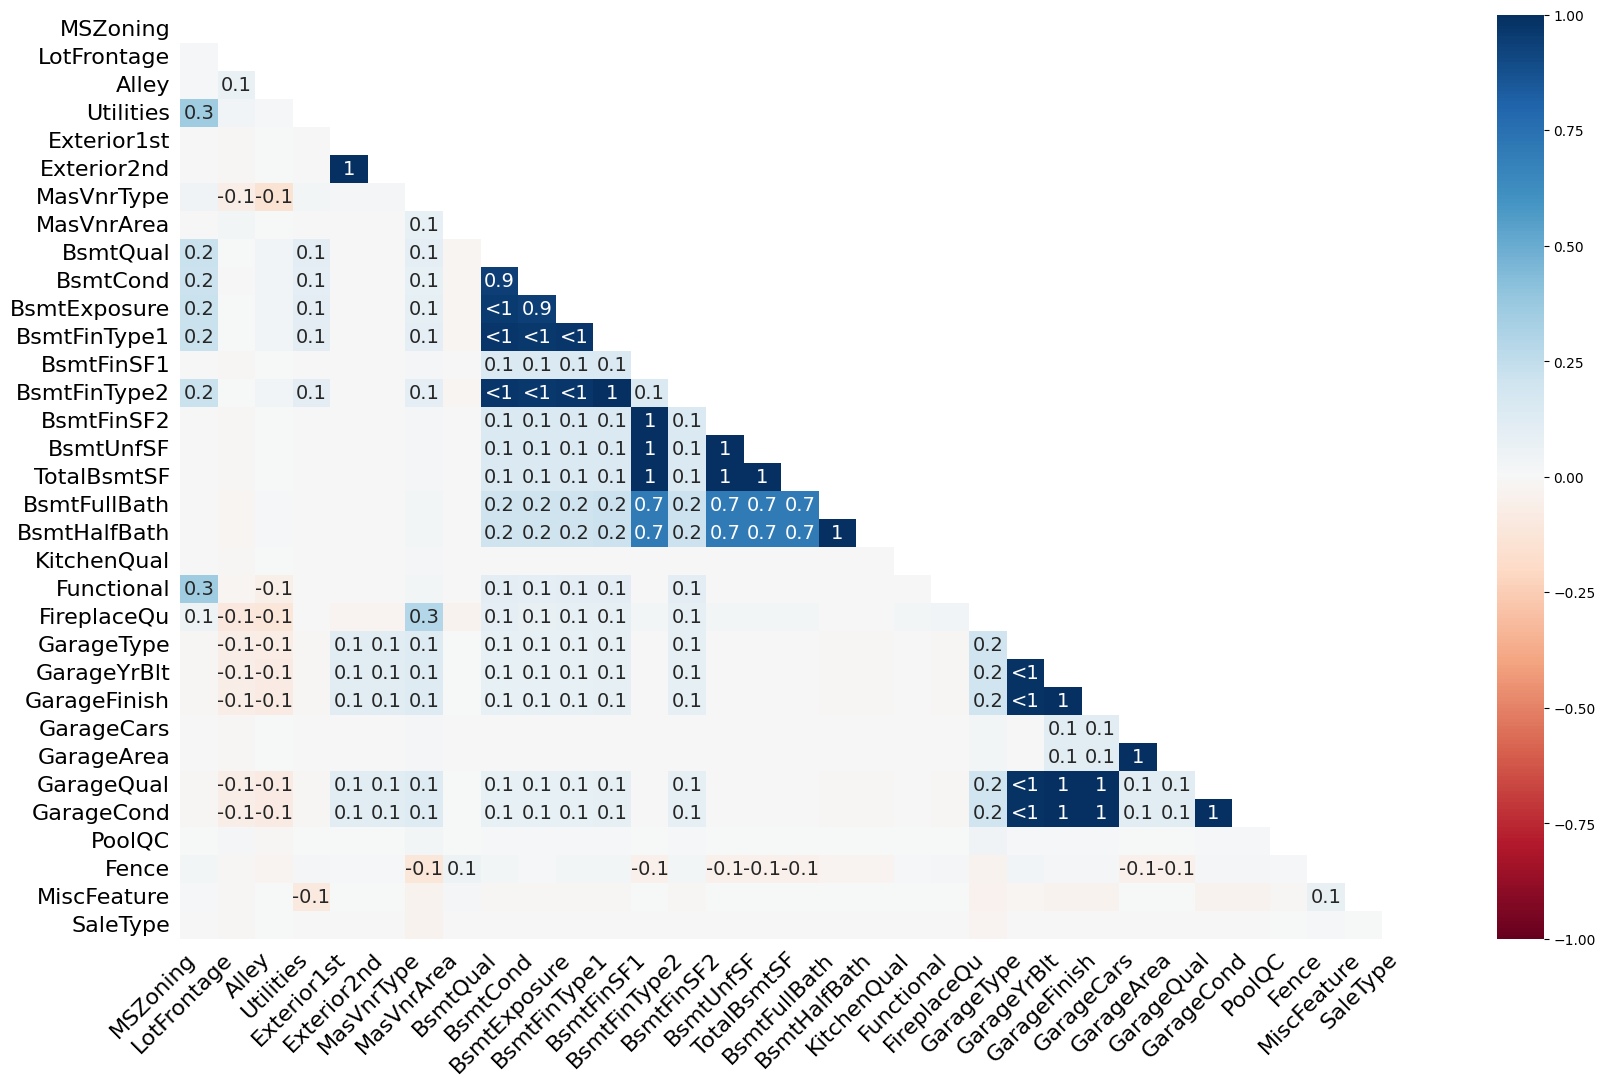

In [30]:
missingno.heatmap(df= train_data) , missingno.heatmap(df= test_data)